# Energy Consumption Prediction

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Loading the Dataset

In [67]:
df = pd.read_csv("C:\\Users\\user\\Downloads\\Energy_Consumption_Prediction.csv")

## Data Preprocessing

### Date Creation

In [70]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

### Extract time-based features



In [73]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

### Define features and target

In [78]:
features = ['number_of_accounts', 'full_fips', 'month', 'year']  
target = 'value'
df.replace([np.inf, -np.inf], np.nan, inplace=True) 

### Handling missing values

In [80]:
df.fillna(df.select_dtypes(include=[np.number]).median(), inplace=True)

### Remove duplicates


In [82]:
df.drop_duplicates(inplace=True)

### Detecting outliers and removing them

In [84]:
def detect_and_remove_outliers(df, cols):
    for col in cols:
        if col in df.columns:  # Check if column exists
            Q1, Q3 = df[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = detect_and_remove_outliers(df, features + [target])

In [85]:
# Check if dataset is empty
if df.empty or len(df) < 5:
    print("Warning: Too many outliers removed! Consider adjusting the IQR threshold.")
    df = pd.read_csv("Energy_Consumption_Prediction.csv")  

In [86]:
# Check if dataframe is empty
print(f"Dataframe size after preprocessing: {df.shape}")

Dataframe size after preprocessing: (86768, 14)


In [87]:
# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")

Missing values:
year                       0
data_class                 0
data_field_display_name    0
data_field                 0
month                      0
full_fips                  0
unit                       0
uer_id                     0
data_stream                0
utility_display_name       0
value                      0
number_of_accounts         0
state_2                    0
date                       0
dtype: int64


In [88]:
# Check if selected features exist in dataset
print(f"Columns in dataset: {df.columns.tolist()}")
print(f"Selected features: {features}")

Columns in dataset: ['year', 'data_class', 'data_field_display_name', 'data_field', 'month', 'full_fips', 'unit', 'uer_id', 'data_stream', 'utility_display_name', 'value', 'number_of_accounts', 'state_2', 'date']
Selected features: ['number_of_accounts', 'full_fips', 'month', 'year']


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86768 entries, 0 to 123712
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   year                     86768 non-null  int32         
 1   data_class               86768 non-null  object        
 2   data_field_display_name  86768 non-null  object        
 3   data_field               86768 non-null  object        
 4   month                    86768 non-null  int32         
 5   full_fips                86768 non-null  int64         
 6   unit                     86768 non-null  object        
 7   uer_id                   86768 non-null  int64         
 8   data_stream              86768 non-null  object        
 9   utility_display_name     86768 non-null  object        
 10  value                    86768 non-null  float64       
 11  number_of_accounts       86768 non-null  int64         
 12  state_2                  86768 non-n

In [90]:
df.describe()

,year,month,full_fips,uer_id,value,number_of_accounts,date
count,86768.000000,86768.000000,86768.000000,86768.000000,86768.000000,86768.000000,86768
mean,2017.994099,6.603921,36060.316707,5.537203,3654.423309,2239.557291,2018-06-17 15:32:03.806011392
min,2016.000000,1.000000,36001.000000,2.000000,-10555.000000,0.000000,2016-01-01 00:00:00
25%,2017.000000,4.000000,36027.000000,5.000000,0.000000,0.000000,2017-03-01 00:00:00
50%,2018.000000,7.000000,36061.000000,6.000000,166.000000,233.000000,2018-06-01 00:00:00
75%,2019.000000,10.000000,36093.000000,6.000000,4053.120000,2428.250000,2019-10-01 00:00:00
max,2020.000000,12.000000,36123.000000,9.000000,35424.157000,20238.000000,2020-12-01 00:00:00
std,1.440180,3.415190,36.938744,1.634162,7200.424689,4142.709925,NaN


## Visualizations

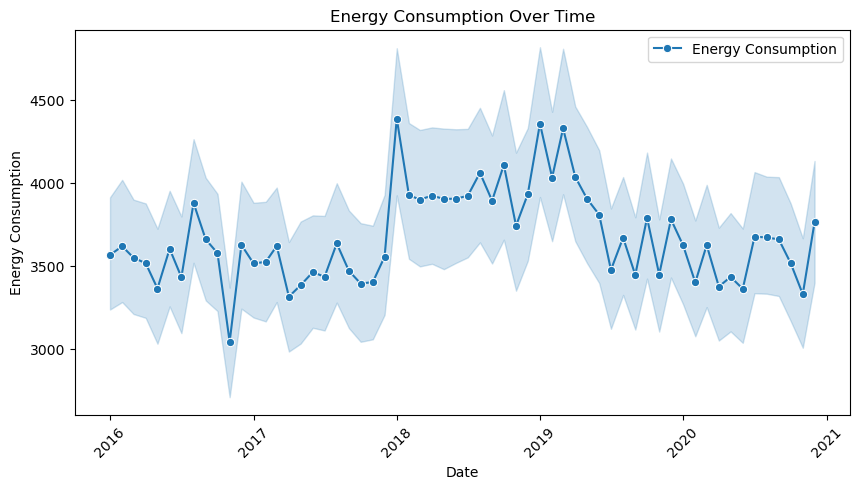

In [92]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='date', y='value', marker='o', label='Energy Consumption')
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.show()

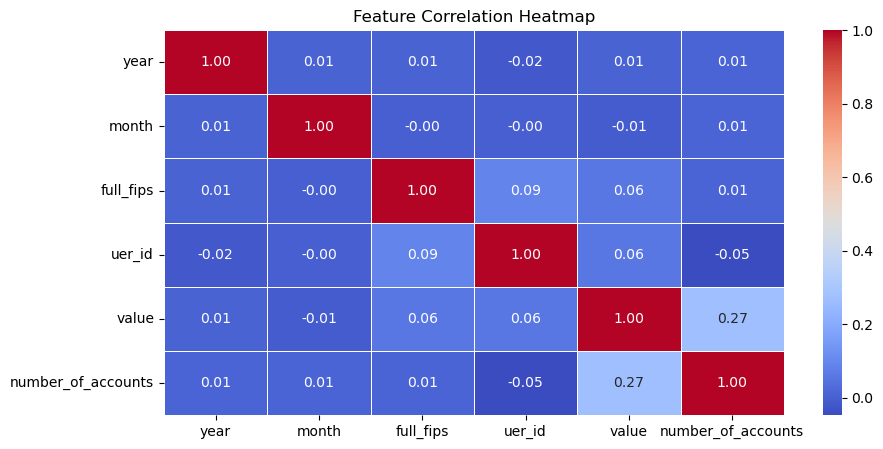

In [93]:
num_df = df.select_dtypes(include=['number', 'float', 'int'])
plt.figure(figsize=(10, 5))
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

## Model Building

### Splitting data into training and testing sets

In [96]:
X, y = df[features], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale data

In [98]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features, index=X_test.index)

### Random Forest Regressor

In [100]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

### XG Boost Regressor

In [102]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Model Evaluation

In [104]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Model:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}\n")
    return r2, mae, mse

rf_r2, rf_mae, rf_mse = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")
xgb_r2, xgb_mae, xgb_mse = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")

Random Forest Model:
R² Score: 0.2468
Mean Absolute Error (MAE): 3448.5281
Mean Squared Error (MSE): 38917956.1492

XGBoost Model:
R² Score: 0.3070
Mean Absolute Error (MAE): 3790.3620
Mean Squared Error (MSE): 35804303.8706



### Best model


In [106]:
models = {"Random Forest": (rf_model, rf_r2, rf_mae, rf_mse), "XGBoost": (xgb_model, xgb_r2, xgb_mae, xgb_mse)}
best_model_name = max(models, key=lambda k: models[k][1]) 
best_model, best_r2, best_mae, best_mse = models[best_model_name]

print(f"Best model selected: {best_model_name}")
print(f"R² Score: {best_r2:.4f}")
print(f"Mean Absolute Error (MAE): {best_mae:.4f}")
print(f"Mean Squared Error (MSE): {best_mse:.4f}")

Best model selected: XGBoost
R² Score: 0.3070
Mean Absolute Error (MAE): 3790.3620
Mean Squared Error (MSE): 35804303.8706


## Predictions

In [137]:
xgb_predictions = xgb_model.predict(X_test_scaled)
prediction_results = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_predictions})
prediction_results

,Actual,Predicted
61021,1.200,11926.844727
21988,7907.000,3469.057129
109173,85.177,5717.548340
78333,-999.000,-987.396912
105272,-999.000,-83.861572
...,...,...
15428,1825.000,1229.842529
88631,3132.685,2100.670898
23885,745.000,4144.875000
536,13747.949,7308.071289


In [110]:
total_months = 120
future_dates = pd.date_range(start=df['date'].max(), periods=total_months, freq='ME')
future_features = pd.DataFrame({'number_of_accounts': [X['number_of_accounts'].mean()] * total_months,
                                'full_fips': [X['full_fips'].mean()] * total_months,
                                'month': future_dates.month,
                                'year': future_dates.year})

future_features_scaled = pd.DataFrame(scaler.transform(future_features), columns=features)
future_predictions = best_model.predict(future_features_scaled)

future_predictions_df = pd.DataFrame({'date': future_dates, 'predicted_energy_consumption': future_predictions})
print(future_predictions_df)

          date  predicted_energy_consumption
0   2020-12-31                   6530.332031
1   2021-01-31                   7744.434082
2   2021-02-28                   6774.661133
3   2021-03-31                   6774.661133
4   2021-04-30                   6822.795898
..         ...                           ...
115 2030-07-31                   6667.765625
116 2030-08-31                   6667.765625
117 2030-09-30                   6667.765625
118 2030-10-31                   6667.765625
119 2030-11-30                   6527.345215

[120 rows x 2 columns]


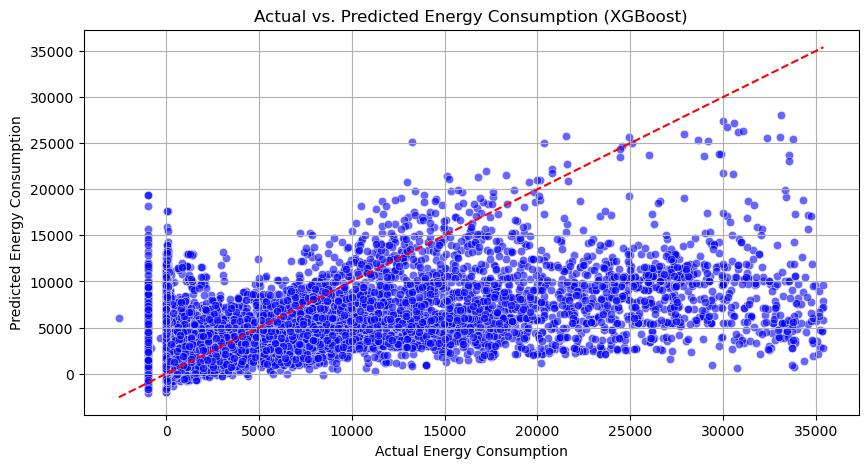

In [44]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=xgb_predictions, color='blue', alpha=0.6)
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='dashed')  
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs. Predicted Energy Consumption (XGBoost)")
plt.grid(True)
plt.show()
